In [2]:
## Import dependencies
import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import recall_score


from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score
from collections import Counter
#from tsfresh import extract_features
#from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import matplotlib
import time

In [3]:
iq_lats = pd.read_csv('../Catalogs/icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('../Catalogs/icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('../Catalogs/earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('../Catalogs/earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('../Catalogs/gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278


In [4]:
stations = 'SCM'

## The code does the following. 

There are 50 iterations, for each iteration it will split the total dataset with 80:20 train and test ratio and then it will randomly select a specified number of samples per class from the training dataset and train the model with those samples and test on the 20% obtained after the initial split and then it stores the sensitivity and specificity for each number of samples the model was trained on. 

## Temporal Features

In [5]:
nos = [100,200,300,400]
sens_class = []
for j in tqdm(nos):
    sens_iter = []
    for i in range(50):
        ## Loading the afs features which is basically a frequency spectrum value. (should be equal to (60x50) == 3000 features)
        X = np.loadtxt("../tsfel_features/temporal/"+stations+".txt")
        ## Loading the labels: 1 for icequakes, 0 for earthquakes. This file should be same for a given station. 
        y = np.loadtxt("../tsfel_features/temporal/"+stations+"_labels.txt")
        ## Transforming the features.
        X = StandardScaler().fit_transform(X)
        ## Splitting the features. 
        X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.20, random_state = 101)


        rus = RandomUnderSampler(sampling_strategy={0:j, 1:j})

        X_resampled, y_resampled = rus.fit_resample(X_Train, y_Train)
        
        forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_resampled, y_resampled)
        
        y_Pred = forest.predict(X_Test)
        
        confusion = confusion_matrix(y_Test, y_Pred)

        # Extract values from the confusion matrix
        true_negatives, false_positives, false_negatives, true_positives = confusion.ravel()

        # Calculate specificity and sensitivity
        specificity = true_negatives / (true_negatives + false_positives)
        sensitivity = true_positives / (true_positives + false_negatives)

        sens_iter.append([sensitivity, specificity])
        
    sens_class.append(sens_iter)
        
        

100%|██████████| 4/4 [00:34<00:00,  8.69s/it]


In [6]:
sens_class = np.array(sens_class)

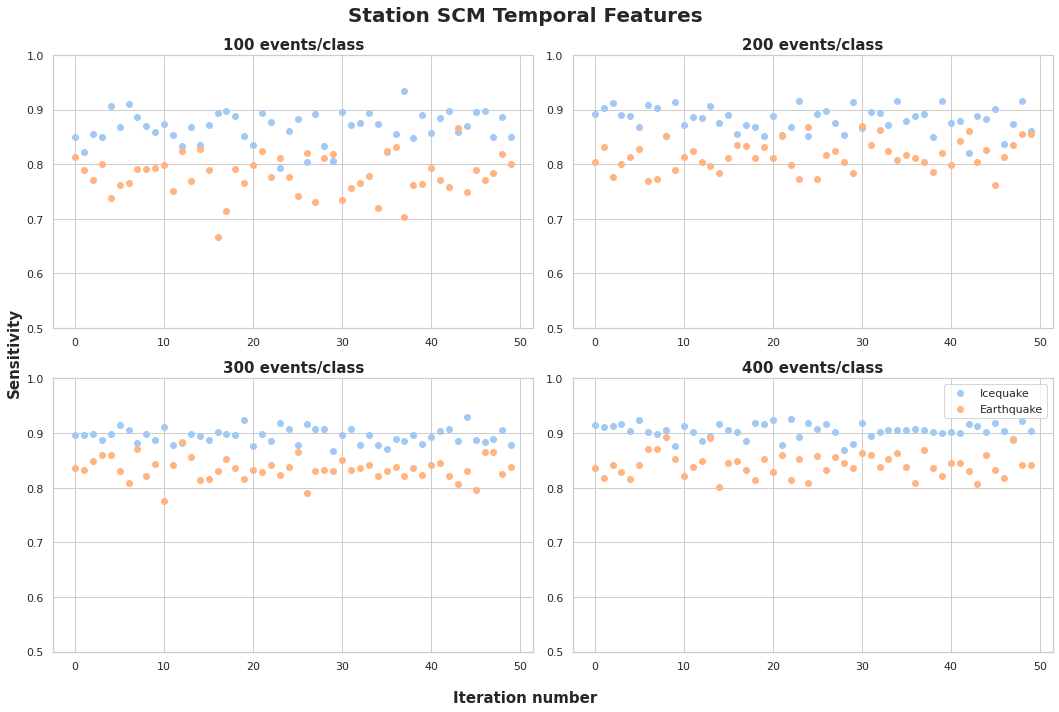

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'sens_class' is defined

# Use Seaborn for styling
sns.set(style="whitegrid", palette="pastel")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[15, 10])

fig.suptitle('Station SCM Temporal Features', fontsize=20, fontweight='bold')

# Plot for 100 events/class
ax[0, 0].scatter(np.arange(50), sens_class[0, :, 0], label='Class 0')
ax[0, 0].scatter(np.arange(50), sens_class[0, :, 1], label='Class 1')
ax[0, 0].set_ylim(0.5, 1)
ax[0, 0].set_title('100 events/class', fontsize=15, fontweight='bold')

# Plot for 200 events/class
ax[0, 1].scatter(np.arange(50), sens_class[1, :, 0], label='Class 0')
ax[0, 1].scatter(np.arange(50), sens_class[1, :, 1], label='Class 1')
ax[0, 1].set_ylim(0.5, 1)
ax[0, 1].set_title('200 events/class', fontsize=15, fontweight='bold')

# Plot for 300 events/class
ax[1, 0].scatter(np.arange(50), sens_class[2, :, 0], label='Class 0')
ax[1, 0].scatter(np.arange(50), sens_class[2, :, 1], label='Class 1')
ax[1, 0].set_ylim(0.5, 1)
ax[1, 0].set_title('300 events/class', fontsize=15, fontweight='bold')

# Plot for 400 events/class
ax[1, 1].scatter(np.arange(50), sens_class[3, :, 0], label='Icequake')
ax[1, 1].scatter(np.arange(50), sens_class[3, :, 1], label='Earthquake')
ax[1, 1].set_ylim(0.5, 1)
ax[1, 1].set_title('400 events/class', fontsize=15, fontweight='bold')
ax[1, 1].legend()

fig.supylabel('Sensitivity', fontsize=15, fontweight='bold')
fig.supxlabel('Iteration number', fontsize=15, fontweight='bold')

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()


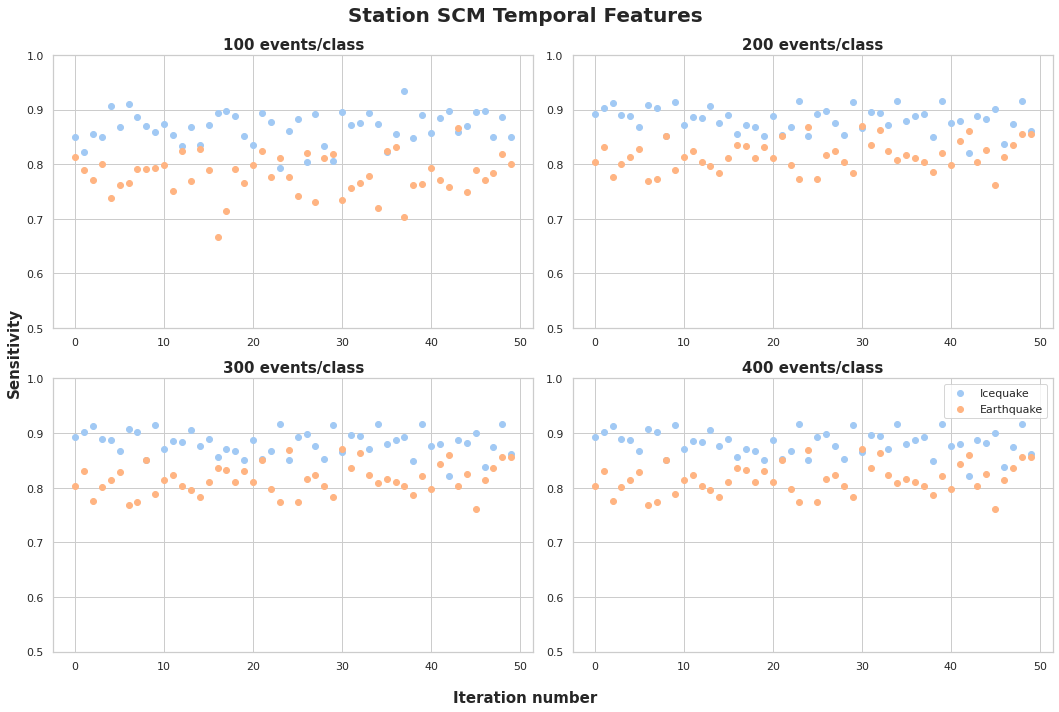

In [8]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [15,10])

fig.suptitle('Station SCM Temporal Features', fontsize = 20, fontweight = 'bold')
ax[0,0].scatter(np.arange(50), sens_class[0,:,0])
ax[0,0].scatter(np.arange(50), sens_class[0,:,1])
ax[0,0].set_ylim(0.5,1)
ax[0,0].set_title('100 events/class', fontsize = 15, fontweight = 'bold')

ax[0,1].scatter(np.arange(50), sens_class[1,:,0])
ax[0,1].scatter(np.arange(50), sens_class[1,:,1])
ax[0,1].set_ylim(0.5,1)
ax[0,1].set_title('200 events/class', fontsize = 15, fontweight = 'bold')


ax[1,0].scatter(np.arange(50), sens_class[1,:,0])
ax[1,0].scatter(np.arange(50), sens_class[1,:,1])
ax[1,0].set_ylim(0.5,1)
ax[1,0].set_title('300 events/class', fontsize = 15, fontweight = 'bold')


ax[1,1].scatter(np.arange(50), sens_class[1,:,0], label = 'Icequake')
ax[1,1].scatter(np.arange(50), sens_class[1,:,1], label = 'Earthquake')
ax[1,1].set_ylim(0.5,1)
ax[1,1].set_title('400 events/class', fontsize = 15, fontweight = 'bold')
ax[1,1].legend()
fig.supylabel('Sensitivity', fontsize = 15, fontweight = 'bold')
fig.supxlabel('Iteration number', fontsize = 15, fontweight = 'bold')

fig.tight_layout()

## Statistical Features

In [9]:
nos = [100,200,300,400]
sens_class = []
for j in tqdm(nos):
    sens_iter = []
    for i in range(50):
        ## Loading the afs features which is basically a frequency spectrum value. (should be equal to (60x50) == 3000 features)
        X = np.loadtxt("../tsfel_features/statistical/"+stations+".txt")
        ## Loading the labels: 1 for icequakes, 0 for earthquakes. This file should be same for a given station. 
        y = np.loadtxt("../tsfel_features/statistical/"+stations+"_labels.txt")
        ## Transforming the features.
        X = StandardScaler().fit_transform(X)
        ## Splitting the features. 
        X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.20, random_state = 101)


        rus = RandomUnderSampler(sampling_strategy={0:j, 1:j})

        X_resampled, y_resampled = rus.fit_resample(X_Train, y_Train)
        
        forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_resampled, y_resampled)
        
        y_Pred = forest.predict(X_Test)
        
        confusion = confusion_matrix(y_Test, y_Pred)

        # Extract values from the confusion matrix
        true_negatives, false_positives, false_negatives, true_positives = confusion.ravel()

        # Calculate specificity and sensitivity
        specificity = true_negatives / (true_negatives + false_positives)
        sensitivity = true_positives / (true_positives + false_negatives)

        sens_iter.append([sensitivity, specificity])
        
    sens_class.append(sens_iter)
        
        

100%|██████████| 4/4 [00:39<00:00,  9.86s/it]


In [10]:
sens_class = np.array(sens_class)

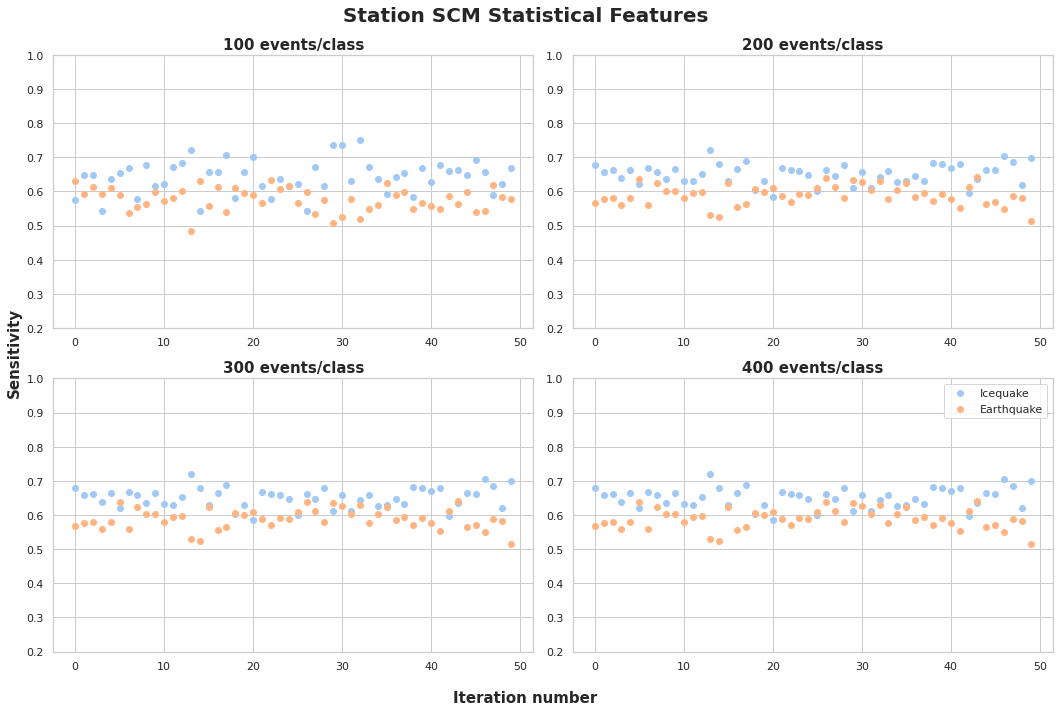

In [11]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [15,10])

fig.suptitle('Station SCM Statistical Features', fontsize = 20, fontweight = 'bold')
ax[0,0].scatter(np.arange(50), sens_class[0,:,0])
ax[0,0].scatter(np.arange(50), sens_class[0,:,1])
ax[0,0].set_ylim(0.2,1)
ax[0,0].set_title('100 events/class', fontsize = 15, fontweight = 'bold')

ax[0,1].scatter(np.arange(50), sens_class[1,:,0])
ax[0,1].scatter(np.arange(50), sens_class[1,:,1])
ax[0,1].set_ylim(0.2,1)
ax[0,1].set_title('200 events/class', fontsize = 15, fontweight = 'bold')


ax[1,0].scatter(np.arange(50), sens_class[1,:,0])
ax[1,0].scatter(np.arange(50), sens_class[1,:,1])
ax[1,0].set_ylim(0.2,1)
ax[1,0].set_title('300 events/class', fontsize = 15, fontweight = 'bold')


ax[1,1].scatter(np.arange(50), sens_class[1,:,0], label = 'Icequake')
ax[1,1].scatter(np.arange(50), sens_class[1,:,1], label = 'Earthquake')
ax[1,1].set_ylim(0.2,1)
ax[1,1].set_title('400 events/class', fontsize = 15, fontweight = 'bold')
ax[1,1].legend()
fig.supylabel('Sensitivity', fontsize = 15, fontweight = 'bold')
fig.supxlabel('Iteration number', fontsize = 15, fontweight = 'bold')

fig.tight_layout()

## Class imbalance

In [12]:
Counter(y_Train)

Counter({1.0: 1934, 0.0: 1636})

In [13]:
stations = 'SCM'
k = [0.2, 0.4, 0.6, 0.8, 1, 1.2]
temp_class = []
for j in tqdm(k):
    temp_iter = []
    for i in tqdm(range(10)):
        ## Loading the afs features which is basically a frequency spectrum value. (should be equal to (60x50) == 3000 features)
        X = np.loadtxt("../tsfel_features/temporal/"+stations+".txt")
        ## Loading the labels: 1 for icequakes, 0 for earthquakes. This file should be same for a given station. 
        y = np.loadtxt("../tsfel_features/temporal/"+stations+"_labels.txt")
        ## Transforming the features.
        X = StandardScaler().fit_transform(X)
        ## Splitting the features. 
        X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.20, random_state = 101)


        rus = RandomUnderSampler(sampling_strategy={0:1500, 1:int(j*1500)})

        X_resampled, y_resampled = rus.fit_resample(X_Train, y_Train)
        
        forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_resampled, y_resampled)
        
        y_Pred = forest.predict(X_Test)
        
        confusion = confusion_matrix(y_Test, y_Pred)

        # Extract values from the confusion matrix
        true_negatives, false_positives, false_negatives, true_positives = confusion.ravel()

        # Calculate specificity and sensitivity
        specificity = true_negatives / (true_negatives + false_positives)
        sensitivity = true_positives / (true_positives + false_negatives)

        temp_iter.append([sensitivity, specificity])
        
    temp_class.append(temp_iter)
        
        

100%|██████████| 6/6 [00:29<00:00,  4.94s/it]


In [14]:
temp_class = np.array(temp_class)
temp_class_mean = np.mean(temp_class, axis = 1)

In [15]:
stations = 'SCM'
k = [0.2, 0.4, 0.6, 0.8, 1, 1.2]
stat_class = []
for j in tqdm(k):
    stat_iter = []
    for i in tqdm(range(10)):
        ## Loading the afs features which is basically a frequency spectrum value. (should be equal to (60x50) == 3000 features)
        X = np.loadtxt("../tsfel_features/statistical/"+stations+".txt")
        ## Loading the labels: 1 for icequakes, 0 for earthquakes. This file should be same for a given station. 
        y = np.loadtxt("../tsfel_features/statistical/"+stations+"_labels.txt")
        ## Transforming the features.
        X = StandardScaler().fit_transform(X)
        ## Splitting the features. 
        X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.20, random_state = 101)


        rus = RandomUnderSampler(sampling_strategy={0:1500, 1:int(j*1500)})

        X_resampled, y_resampled = rus.fit_resample(X_Train, y_Train)
        
        forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_resampled, y_resampled)
        
        y_Pred = forest.predict(X_Test)
        
        confusion = confusion_matrix(y_Test, y_Pred)

        # Extract values from the confusion matrix
        true_negatives, false_positives, false_negatives, true_positives = confusion.ravel()

        # Calculate specificity and sensitivity
        specificity = true_negatives / (true_negatives + false_positives)
        sensitivity = true_positives / (true_positives + false_negatives)

        stat_iter.append([sensitivity, specificity])
        
    stat_class.append(stat_iter)
        
        

100%|██████████| 6/6 [00:34<00:00,  5.75s/it]


In [16]:
stat_class = np.array(stat_class)
stat_class_mean = np.mean(stat_class, axis = 1)

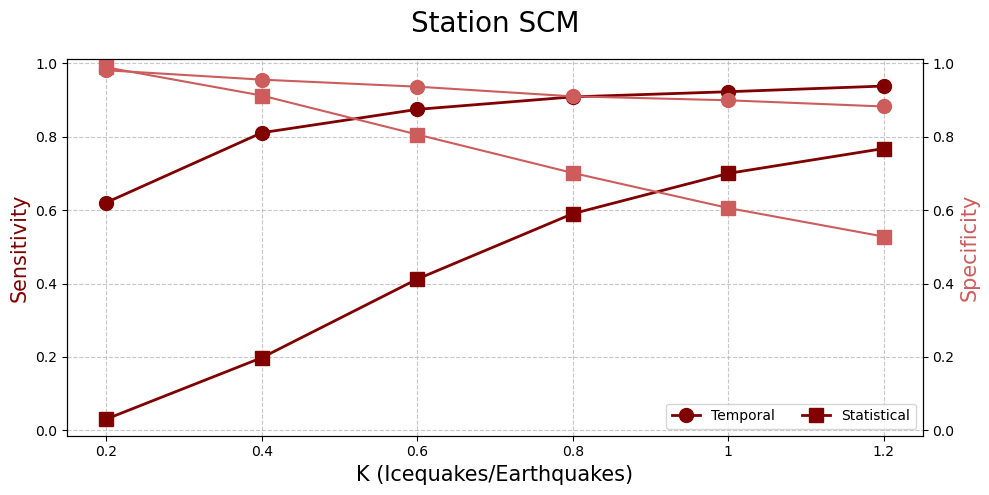

In [24]:
# Assuming 'k', 'temp_class_mean', and 'stat_class_mean' are defined

plt.style.use('default')

plt.rcParams['axes.linewidth'] = 0.5

font = {'family': 'sans-serif',
        'size': 12}

matplotlib.rc('font', **font)

plt.style.use('default')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 5])

fig.suptitle('Station SCM', fontsize=20)

# Plot for Sensitivity
ax.plot(k, temp_class_mean[:, 0], marker='o', markersize = 10, lw = 2, color='maroon', label='Temporal')
ax.plot(k, stat_class_mean[:, 0], marker='s', markersize = 10, lw = 2, color='maroon', label='Statistical')
ax.set_ylabel('Sensitivity', color='maroon', fontsize=15)
ax.legend(loc='lower right', ncol=2)

# Create a second y-axis for Specificity
ax1 = ax.twinx()
ax1.plot(k, temp_class_mean[:, 1], marker='o', markersize = 10, color='indianred', label='Temporal')
ax1.plot(k, stat_class_mean[:, 1], marker='s', markersize = 10, color='indianred', label='Statistical')
ax1.set_ylabel('Specificity', color='indianred', fontsize=15)

# Set the y-axis limits to be the same for both axes
min_y = min(ax.get_ylim()[0], ax1.get_ylim()[0])
max_y = max(ax.get_ylim()[1], ax1.get_ylim()[1])
ax.set_ylim(min_y, max_y)
ax1.set_ylim(min_y, max_y)

# Adjustments for better readability
ax.set_xlabel('K (Icequakes/Earthquakes)', fontsize=15, )
ax.set_xticks(k)
ax.set_xticklabels(k)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)


# Add horizontal and vertical grid lines
ax.grid(True, linestyle='--', alpha=0.7)
# Tight layout
fig.tight_layout()

# Display the plot
plt.show()


In [25]:
stations = 'SCM'
k = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0]
stat_class = []
for j in tqdm(k):
    stat_iter = []
    for i in tqdm(range(10)):
        ## Loading the afs features which is basically a frequency spectrum value. (should be equal to (60x50) == 3000 features)
        X = np.loadtxt("../tsfel_features/temporal/"+stations+".txt")
        ## Loading the labels: 1 for icequakes, 0 for earthquakes. This file should be same for a given station. 
        y = np.loadtxt("../tsfel_features/temporal/"+stations+"_labels.txt")
        ## Transforming the features.
        X = StandardScaler().fit_transform(X)
        ## Splitting the features. 
        X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.20, random_state = 101)


        rus = RandomUnderSampler(sampling_strategy={0:967, 1:int(j*967)})

        X_resampled, y_resampled = rus.fit_resample(X_Train, y_Train)
        
        forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_resampled, y_resampled)
        
        y_Pred = forest.predict(X_Test)
        
        confusion = confusion_matrix(y_Test, y_Pred)

        # Extract values from the confusion matrix
        true_negatives, false_positives, false_negatives, true_positives = confusion.ravel()

        # Calculate specificity and sensitivity
        specificity = true_negatives / (true_negatives + false_positives)
        sensitivity = true_positives / (true_positives + false_negatives)

        stat_iter.append([sensitivity, specificity])
        
    stat_class.append(sens_iter)
        
               

100%|██████████| 10/10 [00:42<00:00,  4.25s/it]
